In [2]:
import math
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as opt
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.distributions import MultivariateNormal

Hemos visto los fundamentos de las transformaciones que componen los Normalizing Flows a través de un **ejemplo en una dimensión**. Hemos **implementado algunas de estas transformaciones para el caso de dos dimensiones** a fin de entender las operaciones que lo componen y visualizar las transformaciones que generan en la densidad de la distribución sobre la que se aplican. Por último vamos a construir una red neuronal forma por una sucesión de estas transformaciones, a esta sucesión la llamamos Normalizing Flow (NF).

Trabajaremos sobre el siguiente dataset:

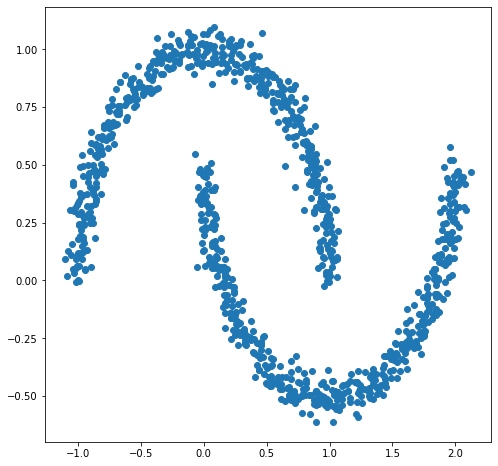

In [2]:
class DatasetMoons:
    
    def sample(self, n):
        X, _ = datasets.make_moons(n_samples = n,
                                   shuffle = True,
                                   noise = 0.05)
        return torch.from_numpy(X.astype('float32'))
    
moons = DatasetMoons()

X = moons.sample(1000)

plt.figure(figsize = (8,8))
plt.scatter(X[:, 0], X[:, 1])
plt.show()

Hemos visto como tras aplicar una de estas funciones a una distribución obtenemos otra distribución. Si a esta distribución le volvemos a aplicar otra de estas funciones volvemos a obtener una nueva distribución. Supongamos que tenemos $f_k$ funciones cumpliendo los assumptions descritos en el anterior notebook. Con la sucesiva aplicación de estas funciones podemos obtener una distribución compleja $q_k$ a partir de una sencilla y conocida $q_0$ (e.g Gaussian):

$x_k =f_k \circ ... \circ f_2 \circ f_1(x_0)$

Podríamos tambien calcular la probabilidad de estas muestras $x_k$ sampleadas de $f_k$:

$ln(q_k(x_k)) = ln(q_0(x_0)) - \sum_{k=1}^{K} ln |det \frac{\partial f_k}{\partial x_{k-1}}|^{-1}$

In [3]:
class FCNN(nn.Module):
    """
    https://github.com/tonyduan/normalizing-flows
    Simple fully connected neural network.
    """
    def __init__(self, in_dim, out_dim, hidden_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, x):
        return self.network(x)

class RealNVP(nn.Module):
    """
    https://github.com/tonyduan/normalizing-flows
    Non-volume preserving flow.
    [Dinh et. al. 2017]
    """
    def __init__(self, dim, hidden_dim = 8, base_network=FCNN):
        super().__init__()
        self.dim = dim
        self.t1 = base_network(dim // 2, dim // 2, hidden_dim)
        self.s1 = base_network(dim // 2, dim // 2, hidden_dim)
        self.t2 = base_network(dim // 2, dim // 2, hidden_dim)
        self.s2 = base_network(dim // 2, dim // 2, hidden_dim)

    def forward(self, x):
        lower, upper = x[:,:self.dim // 2], x[:,self.dim // 2:]
        t1_transformed = self.t1(lower)
        s1_transformed = self.s1(lower)
        upper = t1_transformed + upper * torch.exp(s1_transformed)
        t2_transformed = self.t2(upper)
        s2_transformed = self.s2(upper)
        lower = t2_transformed + lower * torch.exp(s2_transformed)
        z = torch.cat([lower, upper], dim=1)
        log_det = torch.sum(s1_transformed, dim=1) + \
                  torch.sum(s2_transformed, dim=1)
        return z, log_det

    def inverse(self, z):
        lower, upper = z[:,:self.dim // 2], z[:,self.dim // 2:]
        t2_transformed = self.t2(upper)
        s2_transformed = self.s2(upper)
        lower = (lower - t2_transformed) * torch.exp(-s2_transformed)
        t1_transformed = self.t1(lower)
        s1_transformed = self.s1(lower)
        upper = (upper - t1_transformed) * torch.exp(-s1_transformed)
        x = torch.cat([lower, upper], dim=1)
        log_det = torch.sum(-s1_transformed, dim=1) + \
                  torch.sum(-s2_transformed, dim=1)
        return x, log_det

In [4]:
class NormalizingFlowModel(nn.Module):
    """
    https://github.com/tonyduan/normalizing-flows
    """

    def __init__(self, prior, flows):
        super().__init__()
        self.prior = prior
        self.flows = nn.ModuleList(flows)

    def forward(self, x):
        m, _ = x.shape
        log_det = torch.zeros(m)
        for flow in self.flows:
            x, ld = flow.forward(x)
            log_det += ld
        z, prior_logprob = x, self.prior.log_prob(x)
        return z, prior_logprob, log_det

    def inverse(self, z):
        m, _ = z.shape
        log_det = torch.zeros(m)
        for flow in self.flows[::-1]:
            z, ld = flow.inverse(z)
            log_det += ld
        x = z
        return x, log_det

    def sample(self, n_samples):
        z = self.prior.sample((n_samples,))
        x, _ = self.inverse(z)
        return x

In [5]:
prior = MultivariateNormal(loc = torch.zeros(2),
                           scale_tril = torch.diag(torch.ones(2)))

In [6]:
flows = [RealNVP(dim = 2), RealNVP(dim = 2), RealNVP(dim = 2)]

In [7]:
model = NormalizingFlowModel(prior, flows)
print(model)

NormalizingFlowModel(
  (flows): ModuleList(
    (0): RealNVP(
      (t1): FCNN(
        (network): Sequential(
          (0): Linear(in_features=1, out_features=8, bias=True)
          (1): Tanh()
          (2): Linear(in_features=8, out_features=8, bias=True)
          (3): Tanh()
          (4): Linear(in_features=8, out_features=1, bias=True)
        )
      )
      (s1): FCNN(
        (network): Sequential(
          (0): Linear(in_features=1, out_features=8, bias=True)
          (1): Tanh()
          (2): Linear(in_features=8, out_features=8, bias=True)
          (3): Tanh()
          (4): Linear(in_features=8, out_features=1, bias=True)
        )
      )
      (t2): FCNN(
        (network): Sequential(
          (0): Linear(in_features=1, out_features=8, bias=True)
          (1): Tanh()
          (2): Linear(in_features=8, out_features=8, bias=True)
          (3): Tanh()
          (4): Linear(in_features=8, out_features=1, bias=True)
        )
      )
      (s2): FCNN(
        (n

In [8]:
optimizer = opt.SGD(model.parameters(), lr = 1e-4)
print('Number of parameters: ', sum(p.numel() for p in model.parameters()))

Number of parameters:  1164


In [9]:
numIters = 40000
batchSize = 128

model.train()
for iters in range(numIters):
    
    # Sample from the target distribution
    x = moons.sample(n = batchSize)
    
    # Forward pass
    z, prior_logprob, log_det = model(x)
    logprob = prior_logprob + log_det
    loss = -torch.sum(logprob)
    
    # Backward
    model.zero_grad()
    loss.backward()
    
    # Optimizer step
    optimizer.step()
    
    # Print loss
    if (iters % 5000 == 0):
        print('Loss in inter {}: {}'.format(iters, loss.item()))

Loss in epoch 0: 286.45806884765625
Loss in epoch 5000: 106.48920440673828
Loss in epoch 10000: 92.44514465332031
Loss in epoch 15000: 77.8644027709961
Loss in epoch 20000: 79.50331115722656
Loss in epoch 25000: 58.026702880859375
Loss in epoch 30000: 66.991943359375
Loss in epoch 35000: 78.94743347167969


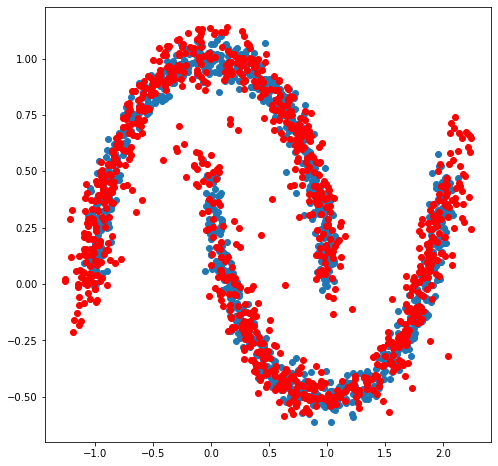

In [10]:
model.eval()

sampleX = model.sample(1000).detach().numpy()

plt.figure(figsize = (8,8))
plt.scatter(X[:, 0], X[:, 1])
plt.scatter(sampleX[:, 0], sampleX[:, 1], c = 'red')
plt.show()

#### References

[1] Tony Duan, https://github.com/tonyduan/normalizing-flows  
[2] Andrej Karpathy, https://github.com/karpathy/pytorch-normalizing-flows